In [95]:
import torch
import torchvision
import torch.nn as nn
import torchgeometry as tgm
import matplotlib.pyplot as plt


In [96]:
def show_image(inp):
    inp = torchvision.transforms.ToPILImage()(inp)
    plt.imshow(inp)
    plt.show()

In [29]:
def transform(inp):
    inp = torchvision.transforms.ToTensor()(inp)
    return torch.cat([inp, inp, inp], 0)

In [ ]:
MNIST_DIR = "/data/theory/robustopt/saachij/dataset_dumps/mnist"

In [30]:
ds = torchvision.datasets.MNIST(MNIST_DIR,
                                train=True, download=False, transform=transform)
dl = torch.utils.data.DataLoader(ds, batch_size=32)
for x, y in dl:
    break

In [80]:

class ConvolutionalWasserstein2D(nn.Module):
    def __init__(self, nin, s, gamma):
        super().__init__()
        self.a = torch.ones(1, nin, s, s)/(s*s)
        self.s = s
        self.nin = nin
        self.gamma = gamma
        
        g_s = s
        if s % 2 == 0:
            g_s = s+1
        self.H = tgm.image.GaussianBlur((g_s, g_s), (gamma, gamma))
        
        
    def sinkhorn(self, mu_0, mu_1, iters):
        w = torch.ones(*mu_0.shape)
        v = torch.ones(*mu_0.shape)
        for i in range(iters):
            v = mu_0 /(self.H(self.a*w))
            w = mu_1 /(self.H(self.a*v))
        out = mu_0 * torch.log(v) + mu_1 * torch.log(w)
        out = torch.flatten(out, 2, 3).unsqueeze(3)
        a = torch.flatten(out, 2, 3).unsqueeze(2)
        out = (a @ out).squeeze(2).squeeze(2)
        return self.gamma * out
    
    def entropic_sharpening(self, x):
        return x
    
    def wass_barycenter(self, mu_s, alphas, iters): # NOT BATCHED
        # mu_s is K x C x H x W
        # alphas is K
        # M is the number of mu_s
        K, C, H, W = mu_s.shape
        
        v = torch.ones_like(mu_s)
        w = torch.ones_like(mu_s)
        for j in range(iters):
            w = mu_s / self.H(self.a * v)
            d = v * self.H(self.a * w)
            mu = torch.ones(C, H, W)
            for i in range(K):
                mu = mu * torch.pow(d[i], alphas[i])
            mu = self.entropic_sharpening(mu)
            v = (v * mu.unsqueeze(0))/d
        return mu
    

In [93]:
# example conv_was
cw = ConvolutionalWasserstein2D(3, 28, 1)
with torch.no_grad():
    inp = x[[0,1]]
    alphas = torch.tensor([0.5, 0.5])
    out = cw.wass_barycenter(inp, alphas, 10)
print(out.shape)

torch.Size([3, 28, 28])


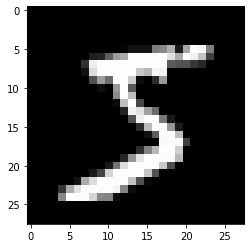

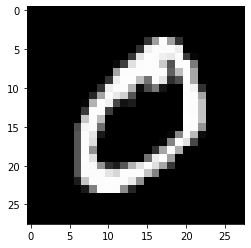

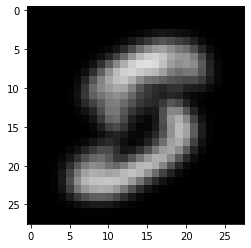

In [94]:
show_image(x[0])
show_image(x[1])
show_image(out)